# Import Required library's

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
print('colab tensorflow version:', tf.__version__)

colab tensorflow version: 2.5.0


# Load The Data And Split Train Data To Validation And Train

Load the Cifar10 dataset

170500096/170498071 [==============================] - 4s 0us/step


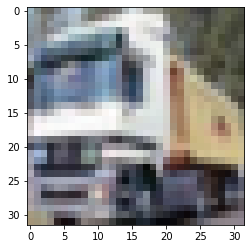

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
plt.imshow(x_train[1], cmap='gray')
plt.show()

Split train and validation data

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2, shuffle=True, random_state=42)

# Data Augmentation

Horizental Flip Data Augmentation

In [14]:
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(x_train)
augmented_data_flip = []
augmented_data_label_flip = []
num_augmented = 0
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=4, seed=42):
  for x, y in zip(X_batch, y_batch):
    augmented_data_flip.append(x)
    augmented_data_label_flip.append(y)
  num_augmented += 4
  if num_augmented == x_train.shape[0]:
    break

Sample wise center Augmentation

In [15]:
datagen = ImageDataGenerator(samplewise_center=True)
datagen.fit(x_train)
augmented_data_center = []
augmented_data_label_center = []
num_augmented = 0
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=4, seed=42):
  for x, y in zip(X_batch, y_batch):
    augmented_data_center.append(x)
    augmented_data_label_center.append(y)
  num_augmented += 4
  if num_augmented == x_train.shape[0]:
    break

# Preparing The Data By Adding Augmented Data To The Data Set, Normalizing The Features And One Hot Encoding The Labels 

Add augmented data's to the train set

In [6]:
x_train = np.concatenate((x_train, np.array(augmented_data_flip), np.array(augmented_data_center)), axis=0)
y_train = np.concatenate((y_train, np.array(augmented_data_label_flip), np.array(augmented_data_label_center)), axis=0)

Check the labels distribution

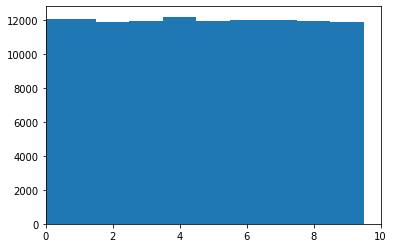

In [7]:
hist, bin_edges = np.histogram(y_train, bins=range(11))
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()   

Normalizing Features

In [8]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

One Hot Encoding train and test labels

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Modify EarlyStopping Callback And Define Some Functions For Plotting And Evaluating The Model

Modify early stopping callback

In [16]:

class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0, monitor='val_loss'):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience
    self.monitor = monitor

  def on_train_begin(self, logs=None):
    if self.monitor in ['loss', 'val_loss']:
      self.best = np.Inf
    else:
      self.best = 0
    self.wait = 0
    self.stopped_epoch = 0
  
  def on_epoch_end(self, epoch,logs=None):
    current_monitor=logs.get(self.monitor)
    bool1 = self.monitor in ['loss', 'val_loss'] and np.less(current_monitor,
                                                             self.best)
    bool2 = self.monitor in ['accuracy', 'val_accuracy'] and np.less(self.best,
                                                                     current_monitor)
    if bool1 or bool2:
      self.best = current_monitor
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      print("\nwait mode, step: %d"% self.wait)
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)
  
  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print("epoch: %d : early stopping."% self.stopped_epoch)

Plot metric value

In [17]:
def plotMetric(history, firstMetric, firstLabel, secondMetric, secondLabel, title, ylabel):
  plt.plot(history.history[firstMetric], label=firstLabel)
  plt.plot(history.history[secondMetric], label=secondLabel)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()

Plot accuracy and loss

In [18]:
def plotAccuracyLoss(history):
  plotMetric(history, 'accuracy', 'train_acc', 'val_accuracy', 'val_acc', 'model accuracy', 'accuracy')
  print()
  plotMetric(history, 'loss', 'tarin_loss', 'val_loss', 'val_loss', 'model Loss', 'loss')

Evaluating the model by calculating the confusion matrix and report other metrics

In [19]:
all_accuracy = {}
def calculateAccuracyModel(model, model_name):
  # evaluate the keras model
  _, accuracy = model.evaluate(x_train, y_train, batch_size=100)
  print('Train Accuracy: %.2f' % (accuracy*100))
  all_accuracy[model_name] = {'Train': accuracy * 100}
  print()
  # evaluate the keras model
  _, accuracy = model.evaluate(x_test, y_test, batch_size=100)
  print('Test Accuracy: %.2f' % (accuracy*100))
  all_accuracy[model_name]['Test'] = accuracy * 100


def reportPerformance(model, x, y):
  y_pred = model.predict(x)
  print('Confusion Matrix')
  print()
  conf_matrix = metrics.confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                        display_labels=range(0, 10))
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax, cmap=plt.cm.Blues)
  plt.show()
  print()
  print(conf_matrix)
  print()
  print('Classification Report')
  print(metrics.classification_report(y.argmax(axis=1), y_pred.argmax(axis=1)))

# Hyper Parameter Tuning

Set the kernel seed for the weights to get same result on different runs

In [20]:
# intitial_weight = keras.initializers.HeUniform(seed=42)
intitial_weight = None

Sample 10000 image for hyper parameter tuning

In [ ]:
# n = int(len(x_train) / 5) 
n = 10000
index = np.random.choice(x_train.shape[0], n, replace=False) 
x_sample_train = x_train[index]
y_sample_train = y_train[index]

Check the hyper parameters for single layer MLP network

In [ ]:
def create_model(activation='relu', units=1024, optimizer='adam'):
	# create model
  model = Sequential()
  model.add(Flatten(input_shape=x_train.shape[1:]))
  model.add(Dense(units=units, kernel_initializer=intitial_weight,activation=activation))
  model.add(Dense(10, kernel_initializer=intitial_weight, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=200, verbose=0)
# define the grid search parameters
activation = ['relu', 'tanh', 'sigmoid',
              'hard_sigmoid', 'linear']
units = [256, 512, 1024, 2048]
param_grid = dict(activation=activation, units=units)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_sample_train, y_sample_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.403600 using {'activation': 'relu', 'units': 512}
0.390800 (0.007454) with: {'activation': 'relu', 'units': 256}
0.403600 (0.009452) with: {'activation': 'relu', 'units': 512}
0.399400 (0.013570) with: {'activation': 'relu', 'units': 1024}
0.394700 (0.012127) with: {'activation': 'relu', 'units': 2048}
0.367700 (0.005862) with: {'activation': 'tanh', 'units': 256}
0.370500 (0.006716) with: {'activation': 'tanh', 'units': 512}
0.362800 (0.018326) with: {'activation': 'tanh', 'units': 1024}
0.365100 (0.011547) with: {'activation': 'tanh', 'units': 2048}
0.388300 (0.003544) with: {'activation': 'sigmoid', 'units': 256}
0.389700 (0.006940) with: {'activation': 'sigmoid', 'units': 512}
0.383600 (0.016889) with: {'activation': 'sigmoid', 'units': 1024}
0.377000 (0.013766) with: {'activation': 'sigmoid', 'units': 2048}
0.380500 (0.016177) with: {'activation': 'hard_sigmoid', 'units': 256}
0.384100 (0.003555) with: {'activation': 'hard_sigmoid', 'units': 512}
0.380100 (0.008157) with: 

Search for appropriate optimizer

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=200, verbose=0)
# define the grid search parameters

optimizers = ['adam', 'rmsprop', 'sgd']
param_grid = dict(optimizer=optimizers, units=[2048])

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_sample_train, y_sample_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.400500 using {'optimizer': 'adam', 'units': 2048}
0.400500 (0.013755) with: {'optimizer': 'adam', 'units': 2048}
0.343700 (0.024347) with: {'optimizer': 'rmsprop', 'units': 2048}
0.367500 (0.008210) with: {'optimizer': 'sgd', 'units': 2048}


# Design MLP Models

Train 2 Layer MLP

In [21]:

model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(2048, kernel_initializer=intitial_weight, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, kernel_initializer=intitial_weight, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(10, kernel_initializer=intitial_weight, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=64, validation_data=(x_val, y_val), shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 6,557,066
Trainable params: 6,557,066
Non-trainable params: 0
______________________________________________

Plot the accuracy and loss

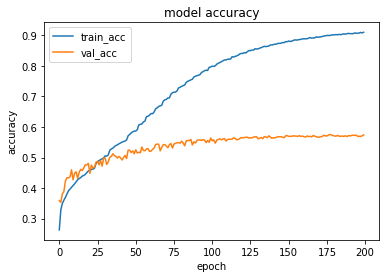

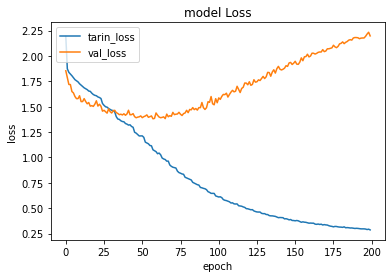

In [22]:
plotAccuracyLoss(history)

Evaluate the model on train and test data

In [23]:
calculateAccuracyModel(model, 'Two_Layer_MLP')

1200/1200 [==============================] - 3s 3ms/step - loss: 0.1180 - accuracy: 0.9694
Train Accuracy: 96.94

100/100 [==============================] - 0s 3ms/step - loss: 2.1732 - accuracy: 0.5661
Test Accuracy: 56.61


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



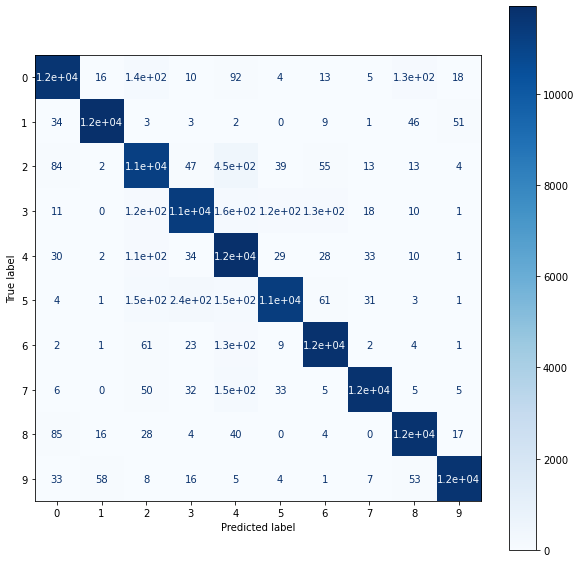


[[11654    16   140    10    92     4    13     5   129    18]
 [   34 11914     3     3     2     0     9     1    46    51]
 [   84     2 11199    47   454    39    55    13    13     4]
 [   11     0   122 11357   164   119   129    18    10     1]
 [   30     2   113    34 11921    29    28    33    10     1]
 [    4     1   149   238   154 11313    61    31     3     1]
 [    2     1    61    23   127     9 11782     2     4     1]
 [    6     0    50    32   147    33     5 11735     5     5]
 [   85    16    28     4    40     0     4     0 11755    17]
 [   33    58     8    16     5     4     1     7    53 11695]]

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     12081
           1       0.99      0.99      0.99     12063
           2       0.94      0.94      0.94     11910
           3       0.97      0.95      0.96     11931
           4       0.91      0.98      0.94     12201
           5       0

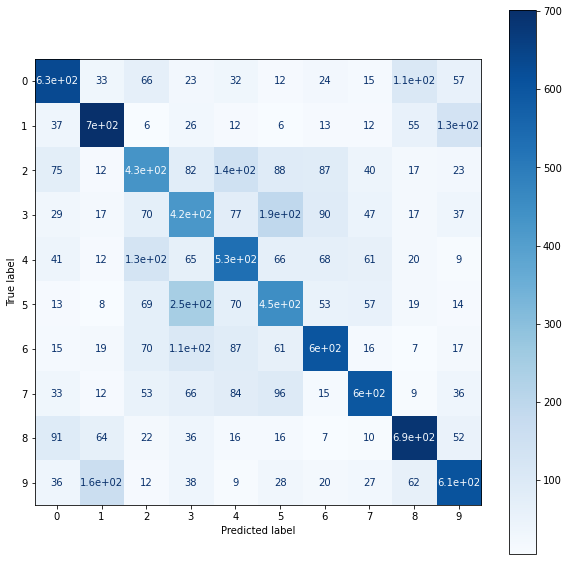


[[632  33  66  23  32  12  24  15 106  57]
 [ 37 701   6  26  12   6  13  12  55 132]
 [ 75  12 431  82 145  88  87  40  17  23]
 [ 29  17  70 423  77 193  90  47  17  37]
 [ 41  12 126  65 532  66  68  61  20   9]
 [ 13   8  69 246  70 451  53  57  19  14]
 [ 15  19  70 106  87  61 602  16   7  17]
 [ 33  12  53  66  84  96  15 596   9  36]
 [ 91  64  22  36  16  16   7  10 686  52]
 [ 36 161  12  38   9  28  20  27  62 607]]

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1000
           1       0.67      0.70      0.69      1000
           2       0.47      0.43      0.45      1000
           3       0.38      0.42      0.40      1000
           4       0.50      0.53      0.52      1000
           5       0.44      0.45      0.45      1000
           6       0.61      0.60      0.61      1000
           7       0.68      0.60      0.63      1000
           8       0.69      0.69      0.69      1000
    

In [24]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

Design MLP model

In [25]:

model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(1024, kernel_initializer=intitial_weight, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, kernel_initializer=intitial_weight, activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(256, kernel_initializer=intitial_weight, activation='linear'))
model.add(Dense(128, kernel_initializer=intitial_weight, activation='relu'))
model.add(Dense(64, kernel_initializer=intitial_weight, activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(25, kernel_initializer=intitial_weight, activation='linear'))
model.add(Dense(10, kernel_initializer=intitial_weight, activation='softmax'))


Compile the MLP model

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

Train the MLP model

In [27]:
# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=250, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/200
480/480 [==============================] - 3s 5ms/step - loss: 1.9232 - accuracy: 0.2978 - val_loss: 1.7176 - val_accuracy: 0.3738
Epoch 2/200
480/480 [==============================] - 2s 5ms/step - loss: 1.6738 - accuracy: 0.4009 - val_loss: 1.6001 - val_accuracy: 0.4221
Epoch 3/200
480/480 [==============================] - 2s 5ms/step - loss: 1.6046 - accuracy: 0.4268 - val_loss: 1.6068 - val_accuracy: 0.4318
Epoch 4/200
480/480 [==============================] - 2s 5ms/step - loss: 1.5548 - accuracy: 0.4489 - val_loss: 1.5576 - val_accuracy: 0.4423
Epoch 5/200
480/480 [==============================] - 2s 5ms/step - loss: 1.5220 - accuracy: 0.4568 - val_loss: 1.5095 - val_accuracy: 0.4636
Epoch 6/200
480/480 [==============================] - 2s 5ms/step - loss: 1.4962 - accuracy: 0.4683 - val_loss: 1.5297 - val_accuracy: 0.4599

wait mode, step: 1
Epoch 7/200
480/480 [==============================] - 2s 5ms/step - loss: 1.4765 - accuracy: 0.4762 - val_loss: 1.4906 - 

Plot  accuracy and loss in epochs

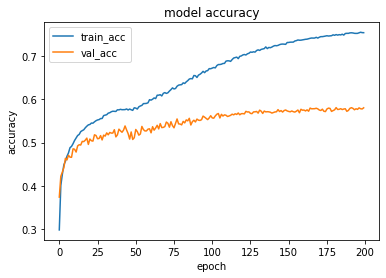

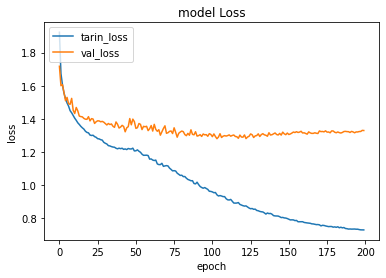

In [28]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [29]:
calculateAccuracyModel(model, 'Second_MLP_Network')

1200/1200 [==============================] - 3s 3ms/step - loss: 0.5320 - accuracy: 0.8273
Train Accuracy: 82.73

100/100 [==============================] - 0s 3ms/step - loss: 1.3301 - accuracy: 0.5760
Test Accuracy: 57.60


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



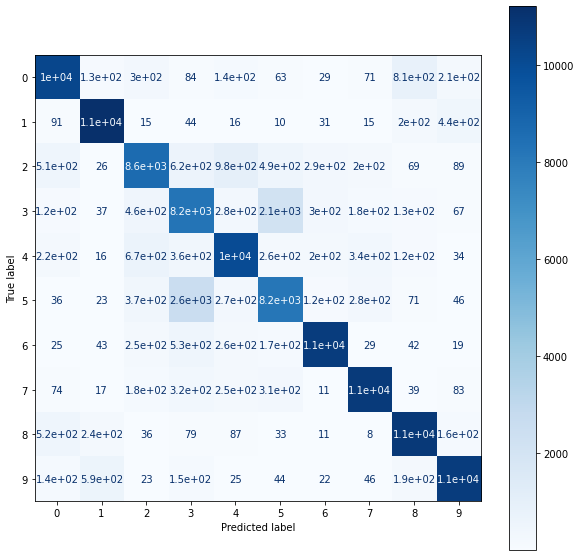


[[10235   132   300    84   143    63    29    71   811   213]
 [   91 11209    15    44    16    10    31    15   196   436]
 [  506    26  8629   622   983   492   294   200    69    89]
 [  122    37   460  8237   281  2123   301   176   127    67]
 [  218    16   670   361  9997   256   197   335   117    34]
 [   36    23   367  2586   274  8157   118   277    71    46]
 [   25    43   246   527   263   170 10648    29    42    19]
 [   74    17   182   324   246   314    11 10728    39    83]
 [  516   236    36    79    87    33    11     8 10784   159]
 [  141   591    23   151    25    44    22    46   190 10647]]

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12081
           1       0.91      0.93      0.92     12063
           2       0.79      0.72      0.76     11910
           3       0.63      0.69      0.66     11931
           4       0.81      0.82      0.82     12201
           5       0

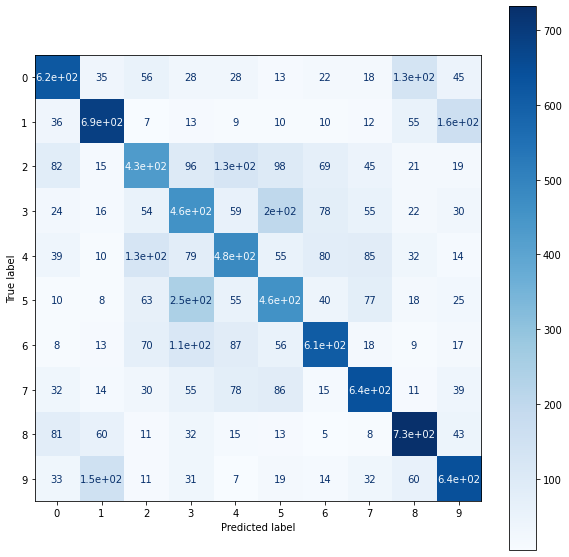


[[621  35  56  28  28  13  22  18 134  45]
 [ 36 689   7  13   9  10  10  12  55 159]
 [ 82  15 429  96 126  98  69  45  21  19]
 [ 24  16  54 459  59 203  78  55  22  30]
 [ 39  10 126  79 480  55  80  85  32  14]
 [ 10   8  63 246  55 458  40  77  18  25]
 [  8  13  70 113  87  56 609  18   9  17]
 [ 32  14  30  55  78  86  15 640  11  39]
 [ 81  60  11  32  15  13   5   8 732  43]
 [ 33 150  11  31   7  19  14  32  60 643]]

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1000
           1       0.68      0.69      0.69      1000
           2       0.50      0.43      0.46      1000
           3       0.40      0.46      0.43      1000
           4       0.51      0.48      0.49      1000
           5       0.45      0.46      0.46      1000
           6       0.65      0.61      0.63      1000
           7       0.65      0.64      0.64      1000
           8       0.67      0.73      0.70      1000
    

In [30]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

# Design MLP Models with Functional API Keras


MLP network without dropout

Model: "cifar10_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3072)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1024)         3146752     flatten_2[0][0]                  
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1024)         0           dense_10[0][0]                   
______________________________________________________________________________________

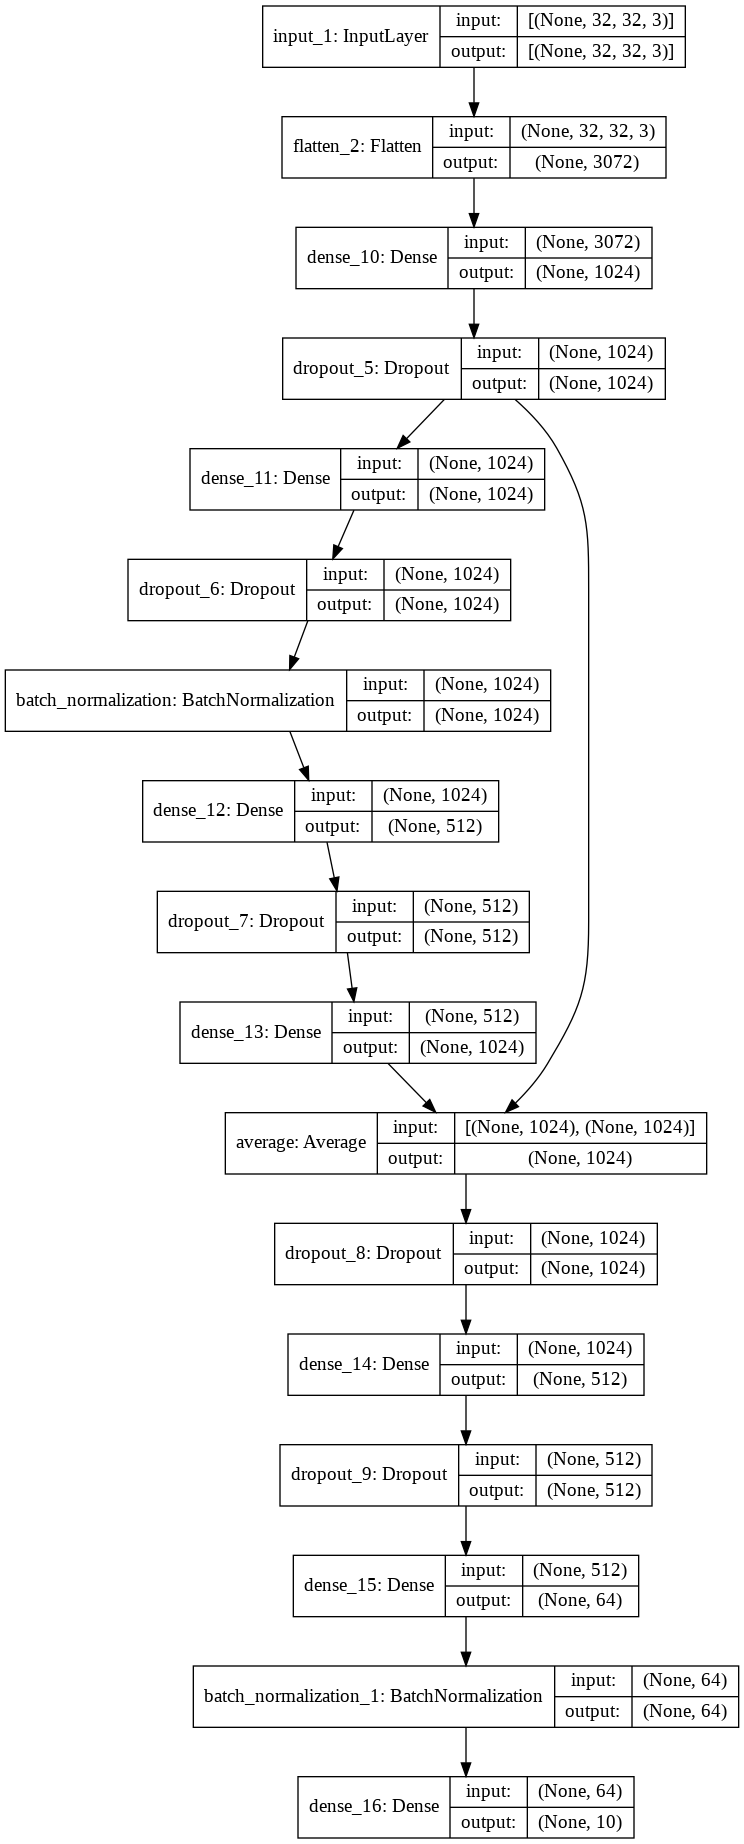

In [31]:
def createModel(dropout=0):
  inputs = keras.Input(shape=x_train.shape[1:])
  flatten = Flatten() (inputs)
  dense = Dense(1024, kernel_initializer=intitial_weight, activation="relu")
  h1 = dense (flatten)
  d1 = Dropout(dropout) (h1)
  h2 = Dense(1024, kernel_initializer=intitial_weight, activation="tanh")(d1)
  d2 = Dropout(dropout) (h2)
  b1 = BatchNormalization() (d2)
  h3 = Dense(512, kernel_initializer=intitial_weight, activation="linear")(b1)
  d3 = Dropout(dropout) (h3)
  h4 = Dense(1024, kernel_initializer=intitial_weight, activation="relu")(d3)
  concat = layers.Average()([d1, h4])
  d3 = Dropout(dropout) (concat)
  h5 = Dense(512, kernel_initializer=intitial_weight, activation="tanh")(d3)
  d4 = Dropout(dropout) (h5)
  h6 = Dense(64, kernel_initializer=intitial_weight, activation="linear")(d4)
  b2 = BatchNormalization() (h6)
  outputs = Dense(10, kernel_initializer=intitial_weight, activation='softmax')(b2)
  model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_model")
  return model

model = createModel(dropout=0)
model.summary()
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)


Compile and train the model

In [32]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    # optimizer=keras.optimizers.RMSProp(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]

history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=64, validation_data=(x_val, y_val), shuffle=True)


Epoch 1/200
1875/1875 [==============================] - 9s 4ms/step - loss: 1.6001 - accuracy: 0.4272 - val_loss: 1.5891 - val_accuracy: 0.4350
Epoch 2/200
1875/1875 [==============================] - 7s 4ms/step - loss: 1.3665 - accuracy: 0.5112 - val_loss: 1.5845 - val_accuracy: 0.4357
Epoch 3/200
1875/1875 [==============================] - 8s 4ms/step - loss: 1.2439 - accuracy: 0.5545 - val_loss: 1.5182 - val_accuracy: 0.4796
Epoch 4/200
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1483 - accuracy: 0.5900 - val_loss: 1.4225 - val_accuracy: 0.5002
Epoch 5/200
1875/1875 [==============================] - 7s 4ms/step - loss: 1.0645 - accuracy: 0.6207 - val_loss: 1.4969 - val_accuracy: 0.4931

wait mode, step: 1
Epoch 6/200
1875/1875 [==============================] - 7s 4ms/step - loss: 0.9895 - accuracy: 0.6486 - val_loss: 1.4769 - val_accuracy: 0.4930

wait mode, step: 2
Epoch 7/200
1875/1875 [==============================] - 7s 4ms/step - loss: 0.9123 - accu

Plot  accuracy and loss in epochs

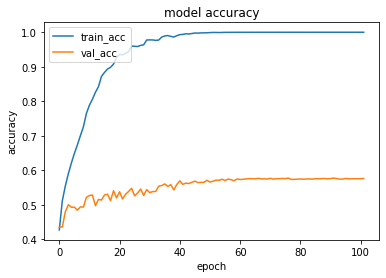

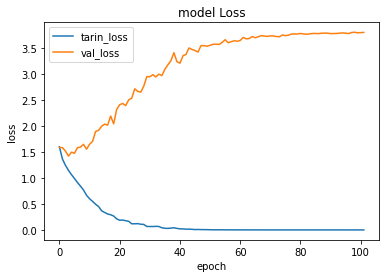

In [33]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [34]:
calculateAccuracyModel(model, 'Functional_API_MLP_Without_Dropout')

1200/1200 [==============================] - 4s 3ms/step - loss: 1.2650e-05 - accuracy: 1.0000
Train Accuracy: 100.00

100/100 [==============================] - 0s 3ms/step - loss: 3.6922 - accuracy: 0.5758
Test Accuracy: 57.58


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



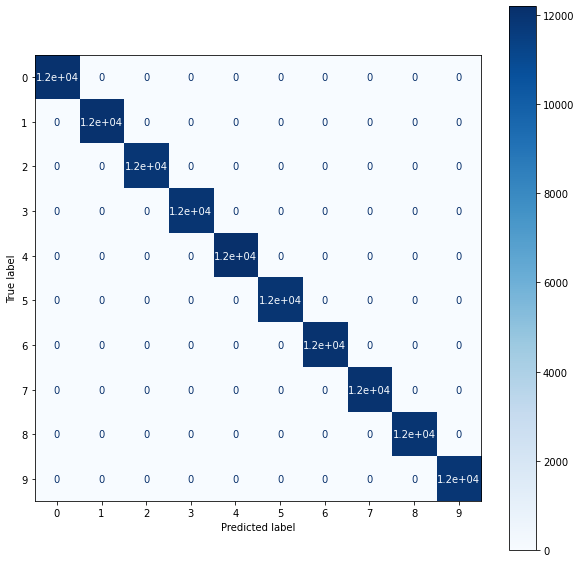


[[12081     0     0     0     0     0     0     0     0     0]
 [    0 12063     0     0     0     0     0     0     0     0]
 [    0     0 11910     0     0     0     0     0     0     0]
 [    0     0     0 11931     0     0     0     0     0     0]
 [    0     0     0     0 12201     0     0     0     0     0]
 [    0     0     0     0     0 11955     0     0     0     0]
 [    0     0     0     0     0     0 12012     0     0     0]
 [    0     0     0     0     0     0     0 12018     0     0]
 [    0     0     0     0     0     0     0     0 11949     0]
 [    0     0     0     0     0     0     0     0     0 11880]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12081
           1       1.00      1.00      1.00     12063
           2       1.00      1.00      1.00     11910
           3       1.00      1.00      1.00     11931
           4       1.00      1.00      1.00     12201
           5       1

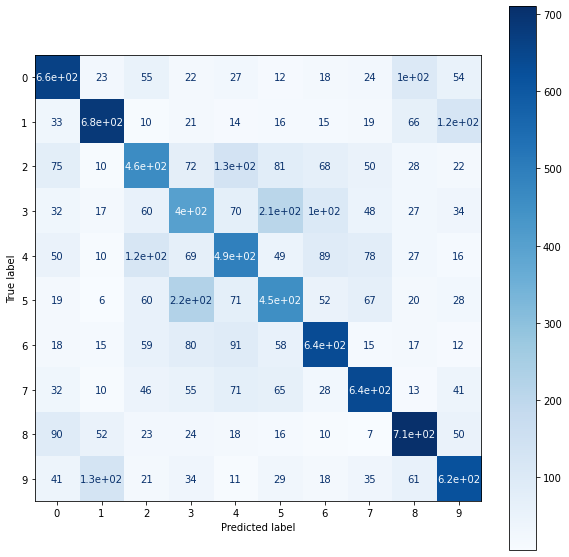


[[663  23  55  22  27  12  18  24 102  54]
 [ 33 684  10  21  14  16  15  19  66 122]
 [ 75  10 461  72 133  81  68  50  28  22]
 [ 32  17  60 401  70 207 104  48  27  34]
 [ 50  10 120  69 492  49  89  78  27  16]
 [ 19   6  60 224  71 453  52  67  20  28]
 [ 18  15  59  80  91  58 635  15  17  12]
 [ 32  10  46  55  71  65  28 639  13  41]
 [ 90  52  23  24  18  16  10   7 710  50]
 [ 41 130  21  34  11  29  18  35  61 620]]

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.66      0.65      1000
           1       0.71      0.68      0.70      1000
           2       0.50      0.46      0.48      1000
           3       0.40      0.40      0.40      1000
           4       0.49      0.49      0.49      1000
           5       0.46      0.45      0.46      1000
           6       0.61      0.64      0.62      1000
           7       0.65      0.64      0.64      1000
           8       0.66      0.71      0.69      1000
    

In [35]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

Design MLP with Functional API Keras with dropout


Model: "cifar10_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3072)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 1024)         3146752     flatten_3[0][0]                  
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 1024)         0           dense_17[0][0]                   
______________________________________________________________________________________

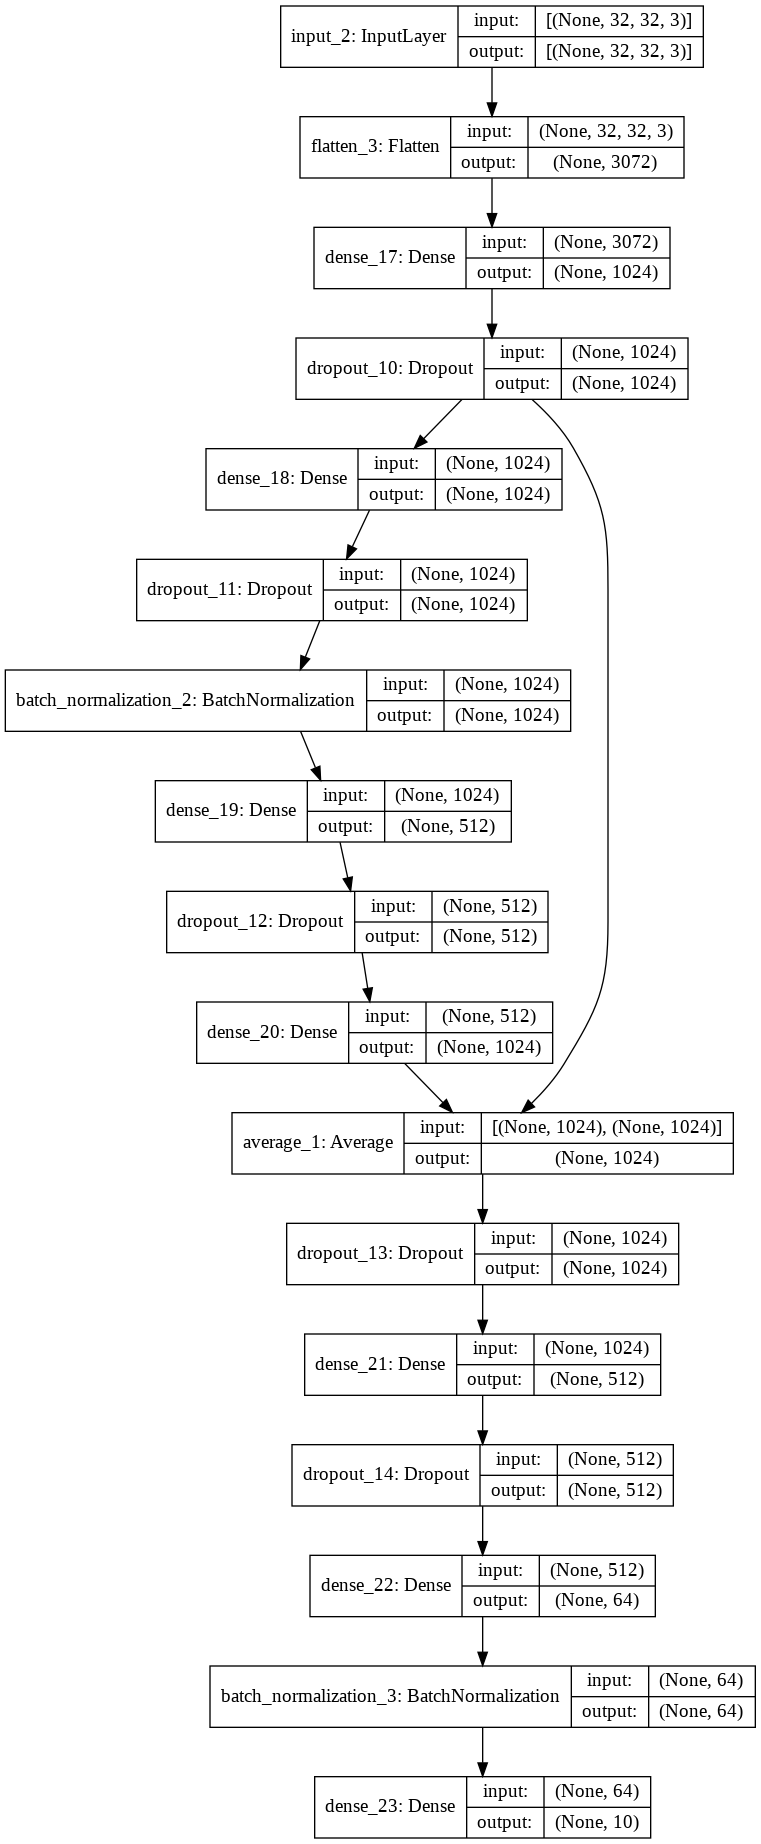

In [36]:
model = createModel(dropout=0.4)
model.summary()
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

Compile and train the model

In [37]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    # optimizer=keras.optimizers.RMSProp(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint(filepath='bestModel.h5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
]

history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=64, validation_data=(x_val, y_val), shuffle=True)
# model.save('bestModel.h5')

Epoch 1/200
1875/1875 [==============================] - 9s 4ms/step - loss: 1.8764 - accuracy: 0.3153 - val_loss: 1.6758 - val_accuracy: 0.3963

Epoch 00001: val_loss improved from inf to 1.67579, saving model to bestModel.h5
Epoch 2/200
  27/1875 [..............................] - ETA: 7s - loss: 1.6772 - accuracy: 0.3987

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1875/1875 [==============================] - 7s 4ms/step - loss: 1.6687 - accuracy: 0.3987 - val_loss: 1.6072 - val_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.67579 to 1.60717, saving model to bestModel.h5
Epoch 3/200
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5880 - accuracy: 0.4305 - val_loss: 1.5734 - val_accuracy: 0.4350

wait mode, step: 1

Epoch 00003: val_loss improved from 1.60717 to 1.57344, saving model to bestModel.h5
Epoch 4/200
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5354 - accuracy: 0.4523 - val_loss: 1.4705 - val_accuracy: 0.4768

Epoch 00004: val_loss improved from 1.57344 to 1.47050, saving model to bestModel.h5
Epoch 5/200
1875/1875 [==============================] - 7s 4ms/step - loss: 1.4949 - accuracy: 0.4668 - val_loss: 1.5264 - val_accuracy: 0.4635

wait mode, step: 1

Epoch 00005: val_loss did not improve from 1.47050
Epoch 6/200
1875/1875 [==============================] - 8s 4ms/step - loss: 1.461

Plot  accuracy and loss in epochs

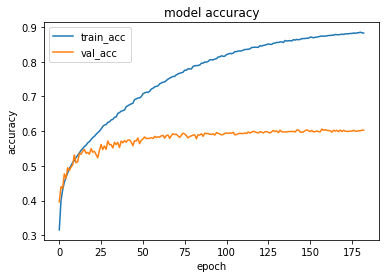

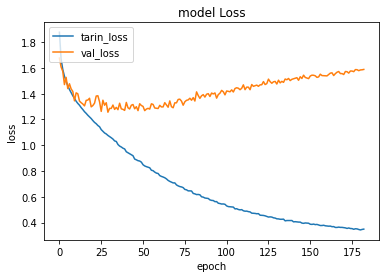

In [38]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [39]:
calculateAccuracyModel(model, 'Functional_API_MLP_With_Dropout')

1200/1200 [==============================] - 4s 3ms/step - loss: 0.1238 - accuracy: 0.9637
Train Accuracy: 96.37

100/100 [==============================] - 0s 3ms/step - loss: 1.5562 - accuracy: 0.5962
Test Accuracy: 59.62


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



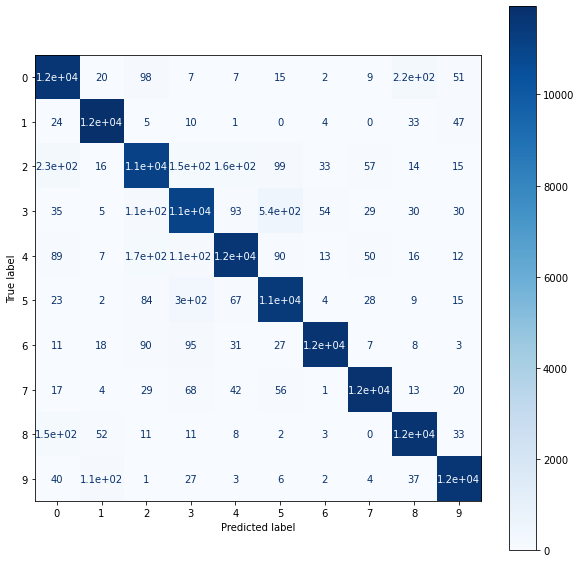


[[11657    20    98     7     7    15     2     9   215    51]
 [   24 11939     5    10     1     0     4     0    33    47]
 [  230    16 11136   151   159    99    33    57    14    15]
 [   35     5   106 11014    93   535    54    29    30    30]
 [   89     7   168   106 11650    90    13    50    16    12]
 [   23     2    84   296    67 11427     4    28     9    15]
 [   11    18    90    95    31    27 11722     7     8     3]
 [   17     4    29    68    42    56     1 11768    13    20]
 [  149    52    11    11     8     2     3     0 11680    33]
 [   40   113     1    27     3     6     2     4    37 11647]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12081
           1       0.98      0.99      0.99     12063
           2       0.95      0.94      0.94     11910
           3       0.93      0.92      0.93     11931
           4       0.97      0.95      0.96     12201
           5       0

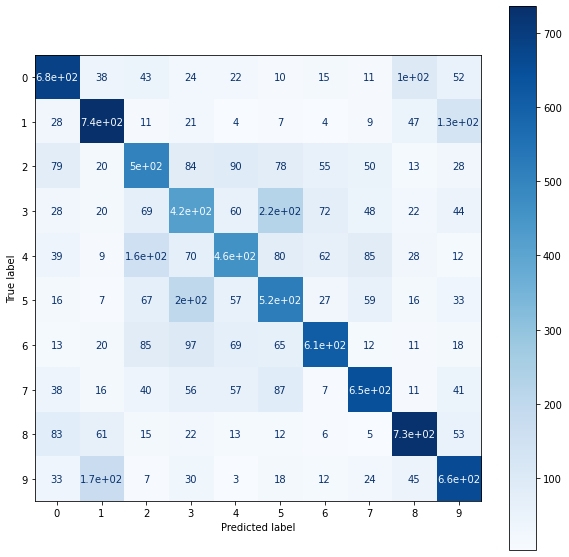


[[685  38  43  24  22  10  15  11 100  52]
 [ 28 736  11  21   4   7   4   9  47 133]
 [ 79  20 503  84  90  78  55  50  13  28]
 [ 28  20  69 416  60 221  72  48  22  44]
 [ 39   9 155  70 460  80  62  85  28  12]
 [ 16   7  67 201  57 517  27  59  16  33]
 [ 13  20  85  97  69  65 610  12  11  18]
 [ 38  16  40  56  57  87   7 647  11  41]
 [ 83  61  15  22  13  12   6   5 730  53]
 [ 33 170   7  30   3  18  12  24  45 658]]

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      1000
           1       0.67      0.74      0.70      1000
           2       0.51      0.50      0.50      1000
           3       0.41      0.42      0.41      1000
           4       0.55      0.46      0.50      1000
           5       0.47      0.52      0.49      1000
           6       0.70      0.61      0.65      1000
           7       0.68      0.65      0.66      1000
           8       0.71      0.73      0.72      1000
    

In [40]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

# Design CNN Models

Inception V1

In [55]:
# function for creating a projected inception module
def inception_module1(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(layer_in)
  # 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv3)
  # 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv5)
  # 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
  return layer_out# function for creating a projected inception module

Inception V3

In [56]:
# function for creating a projected inception module
def inception_module3(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(layer_in)
  # 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(layer_in)
  conv3_1 = Conv2D(f2_out, (1,3), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv3)
  conv3_2 = Conv2D(f2_out, (3,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv3_1)
  # 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(layer_in)
  conv3_1_1 = Conv2D(f3_out, (1,3), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv5)
  conv3_1_2 = Conv2D(f3_out, (3,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv3_1_1)
  conv3_2_1 = Conv2D(f3_out, (1,3), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv3_1_2)
  conv3_2_2 = Conv2D(f3_out, (3,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(conv3_2_1)
  # 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', kernel_initializer=intitial_weight, activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv3_2, conv3_2_2, pool], axis=-1)
  return layer_out# function for creating a projected inception module


CNN model with inception module 1

Model: "cifar10_cnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 26, 26, 32)   4736        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 13, 13, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 13, 13, 32)   128         max_pooling2d_4[0][0]            
__________________________________________________________________________________

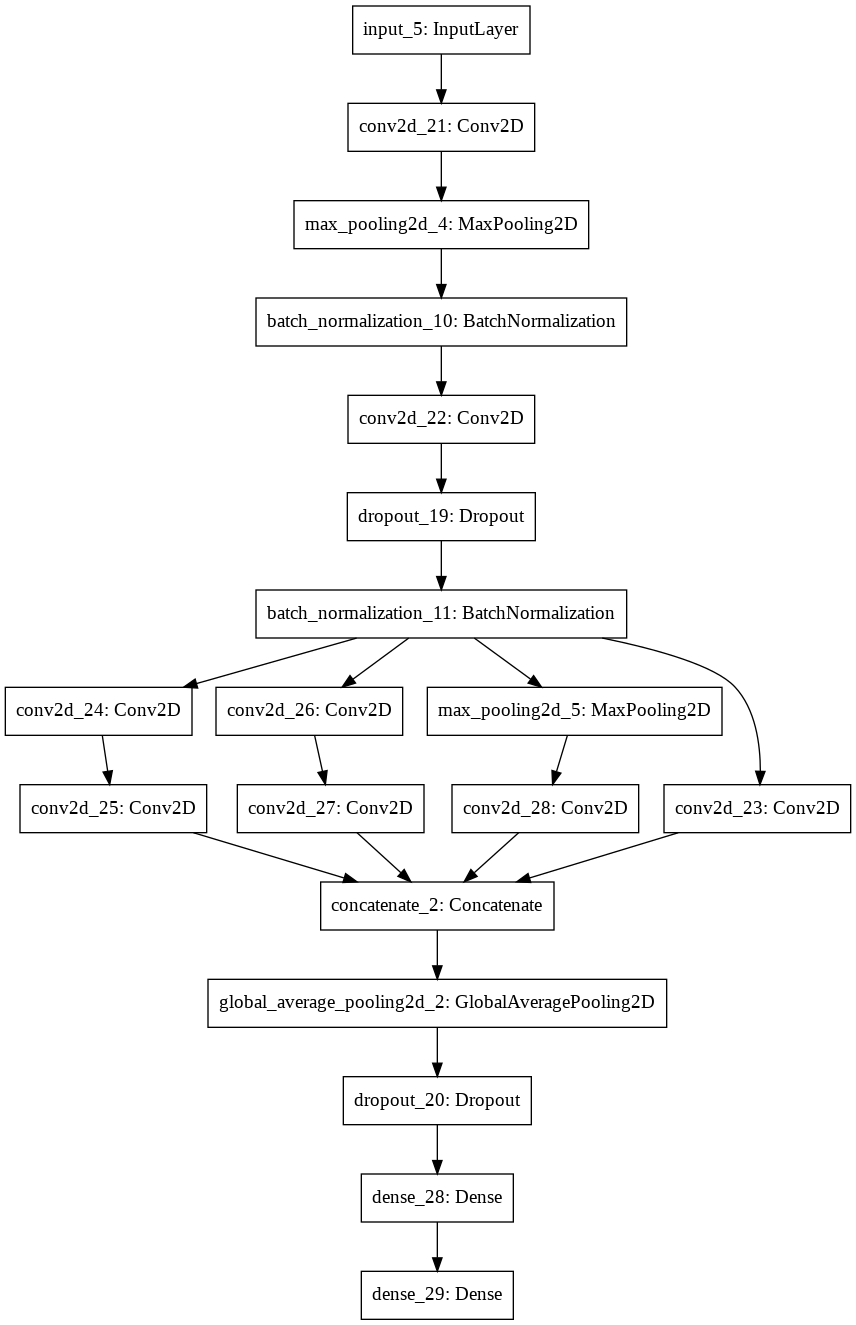

In [57]:

inputs = keras.Input(shape=x_train.shape[1:])
conv1 = Conv2D(32, kernel_size=7, kernel_initializer=intitial_weight, activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(conv1)
b1 = BatchNormalization() (pool1)
conv2 = Conv2D(64, kernel_size=3, kernel_initializer=intitial_weight, activation='relu')(b1)
d0 = Dropout(0.2) (conv2)
b2 = BatchNormalization() (d0)

layer = inception_module1(b2, 32, 48, 64, 8, 16, 16)
globalPooling1 = GlobalAveragePooling2D()(layer)
d1 = Dropout(0.4)(globalPooling1)
hidden2 = Dense(32, kernel_initializer=intitial_weight, activation='linear')(d1)
outputs = Dense(10, kernel_initializer=intitial_weight, activation='softmax')(hidden2)
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_cnn_model")

model.summary()
keras.utils.plot_model(model, "my_first_cnn_model_with_shape_info.png")

Compile and train first cnn model

In [58]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    # optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    optimizer=keras.optimizers.Adam(),
    # optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
    # optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(5, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=100, callbacks=my_callbacks,
                    batch_size=64,  validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 12s 6ms/step - loss: 1.5588 - accuracy: 0.4241 - val_loss: 1.2959 - val_accuracy: 0.5400
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 1.2261 - accuracy: 0.5600 - val_loss: 1.2770 - val_accuracy: 0.5498
Epoch 3/100
1875/1875 [==============================] - 11s 6ms/step - loss: 1.1079 - accuracy: 0.6050 - val_loss: 1.0646 - val_accuracy: 0.6190
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 1.0298 - accuracy: 0.6341 - val_loss: 1.1929 - val_accuracy: 0.5762

wait mode, step: 1
Epoch 5/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.9764 - accuracy: 0.6538 - val_loss: 1.0385 - val_accuracy: 0.6337
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.9299 - accuracy: 0.6711 - val_loss: 0.9275 - val_accuracy: 0.6646
Epoch 7/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.8953 - accuracy: 0.6837 

Plot  accuracy and loss in epochs

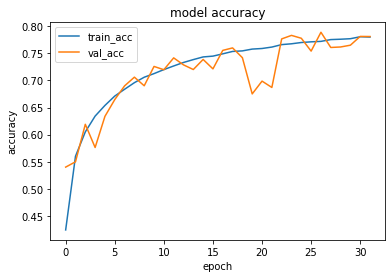

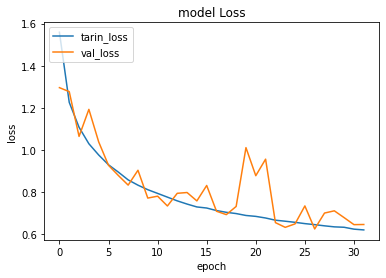

In [59]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [60]:
calculateAccuracyModel(model, 'CNN_Inception_V1')

1200/1200 [==============================] - 5s 4ms/step - loss: 0.4518 - accuracy: 0.8453
Train Accuracy: 84.53

100/100 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.7844
Test Accuracy: 78.44


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



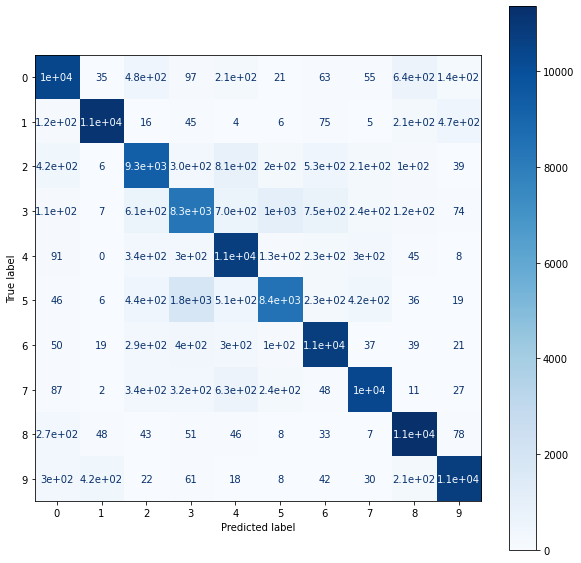


[[10344    35   479    97   208    21    63    55   640   139]
 [  122 11113    16    45     4     6    75     5   206   471]
 [  425     6  9290   305   809   197   529   208   102    39]
 [  111     7   612  8285   705  1025   749   245   118    74]
 [   91     0   342   303 10757   131   229   295    45     8]
 [   46     6   444  1798   508  8445   230   423    36    19]
 [   50    19   286   398   299   102 10761    37    39    21]
 [   87     2   343   318   631   242    48 10309    11    27]
 [  274    48    43    51    46     8    33     7 11361    78]
 [  302   415    22    61    18     8    42    30   208 10774]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     12081
           1       0.95      0.92      0.94     12063
           2       0.78      0.78      0.78     11910
           3       0.71      0.69      0.70     11931
           4       0.77      0.88      0.82     12201
           5       0

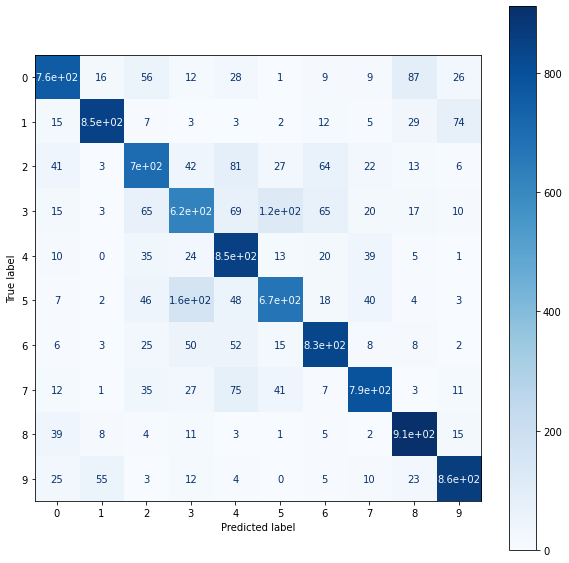


[[756  16  56  12  28   1   9   9  87  26]
 [ 15 850   7   3   3   2  12   5  29  74]
 [ 41   3 701  42  81  27  64  22  13   6]
 [ 15   3  65 620  69 116  65  20  17  10]
 [ 10   0  35  24 853  13  20  39   5   1]
 [  7   2  46 162  48 670  18  40   4   3]
 [  6   3  25  50  52  15 831   8   8   2]
 [ 12   1  35  27  75  41   7 788   3  11]
 [ 39   8   4  11   3   1   5   2 912  15]
 [ 25  55   3  12   4   0   5  10  23 863]]

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1000
           1       0.90      0.85      0.88      1000
           2       0.72      0.70      0.71      1000
           3       0.64      0.62      0.63      1000
           4       0.70      0.85      0.77      1000
           5       0.76      0.67      0.71      1000
           6       0.80      0.83      0.82      1000
           7       0.84      0.79      0.81      1000
           8       0.83      0.91      0.87      1000
    

In [61]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

CNN model with inception module 3

Model: "cifar10_cnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 26, 26, 32)   4736        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 32)   0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 12, 12, 32)   128         max_pooling2d_6[0][0]            
__________________________________________________________________________________

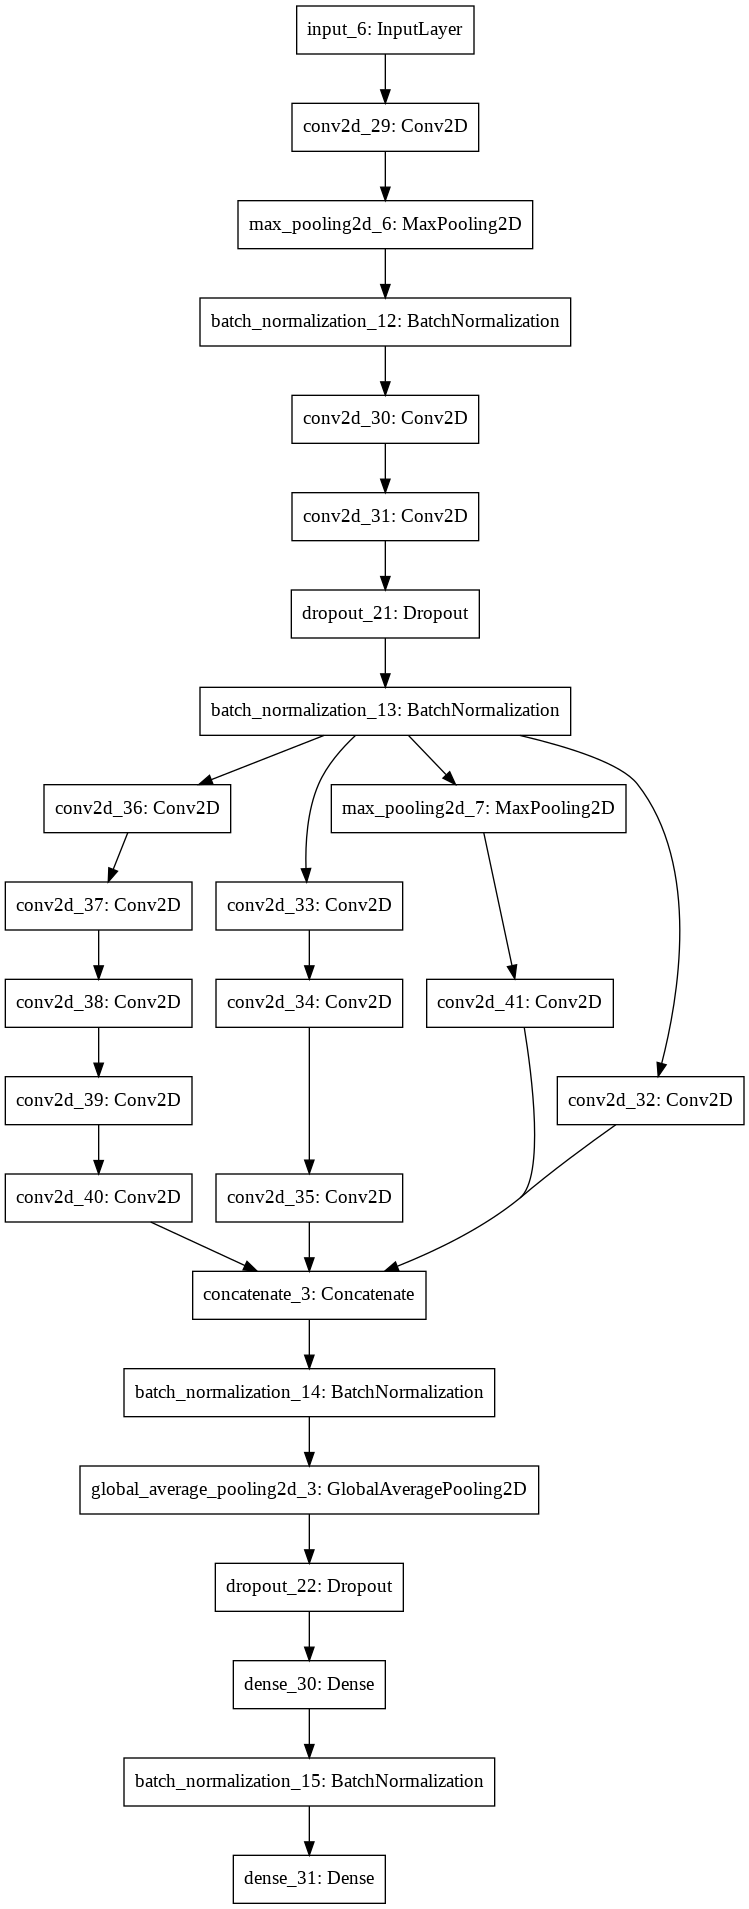

In [62]:
inputs = keras.Input(shape=x_train.shape[1:])
conv1 = Conv2D(32, kernel_size=7, activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=3, strides=2)(conv1)
b1 = BatchNormalization() (pool1)
conv2 = Conv2D(64, kernel_size=(1, 3), activation='relu')(b1)
conv2 = Conv2D(64, kernel_size=(3, 1), activation='relu')(conv2)
d0 = Dropout(0.2)(conv2)
b2 = BatchNormalization() (d0)

layer = inception_module3(b2, 32, 48, 64, 8, 16, 16)
b3 = BatchNormalization() (layer)
globalPooling1 = GlobalAveragePooling2D()(b3)
d1 = Dropout(0.4)(globalPooling1)
fc1 = Dense(32, activation='linear')(d1)
b4 = BatchNormalization() (fc1)
outputs = Dense(10, activation='softmax')(b4)
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_cnn_model")

model.summary()
keras.utils.plot_model(model, "my_first_cnn_model_with_shape_info.png")

Compile and train first cnn model

In [63]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    # optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    optimizer=keras.optimizers.Adam(),
    # optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
    # optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(5, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=100, callbacks=my_callbacks,
                    batch_size=64,  validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 14s 7ms/step - loss: 1.4847 - accuracy: 0.4574 - val_loss: 1.3595 - val_accuracy: 0.5068
Epoch 2/100
1875/1875 [==============================] - 13s 7ms/step - loss: 1.1251 - accuracy: 0.5989 - val_loss: 1.3629 - val_accuracy: 0.5253
Epoch 3/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.9903 - accuracy: 0.6525 - val_loss: 0.8971 - val_accuracy: 0.6775
Epoch 4/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.8904 - accuracy: 0.6872 - val_loss: 0.8747 - val_accuracy: 0.6873
Epoch 5/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.8246 - accuracy: 0.7123 - val_loss: 0.8449 - val_accuracy: 0.7093
Epoch 6/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.7757 - accuracy: 0.7307 - val_loss: 1.0273 - val_accuracy: 0.6515

wait mode, step: 1
Epoch 7/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.7351 - accuracy: 0.7437 

Plot  accuracy and loss in epochs

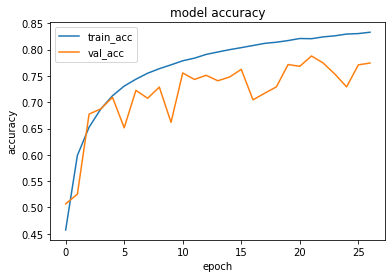

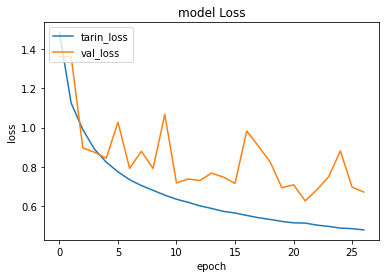

In [64]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [65]:
calculateAccuracyModel(model, 'CNN_Inception_V3')

1200/1200 [==============================] - 5s 4ms/step - loss: 0.3682 - accuracy: 0.8752
Train Accuracy: 87.52

100/100 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.7879
Test Accuracy: 78.79


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



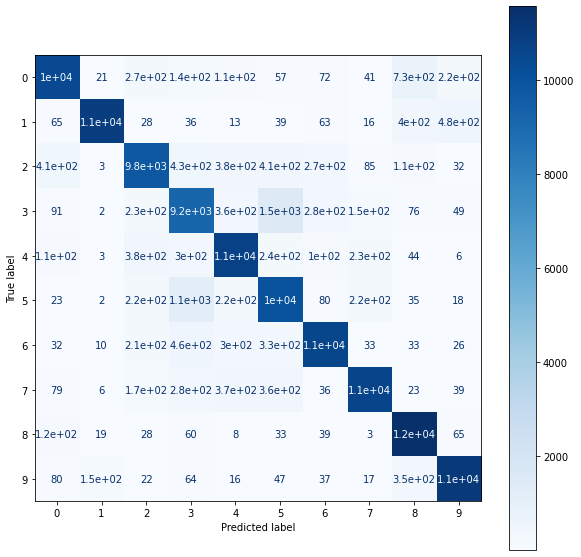


[[10412    21   272   141   112    57    72    41   729   224]
 [   65 10924    28    36    13    39    63    16   398   481]
 [  413     3  9772   433   383   407   274    85   108    32]
 [   91     2   232  9204   359  1494   277   147    76    49]
 [  108     3   376   303 10785   242   102   232    44     6]
 [   23     2   217  1117   216 10023    80   224    35    18]
 [   32    10   211   461   295   333 10578    33    33    26]
 [   79     6   172   281   374   364    36 10644    23    39]
 [  118    19    28    60     8    33    39     3 11576    65]
 [   80   147    22    64    16    47    37    17   346 11104]]

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.89     12081
           1       0.98      0.91      0.94     12063
           2       0.86      0.82      0.84     11910
           3       0.76      0.77      0.77     11931
           4       0.86      0.88      0.87     12201
           5       0

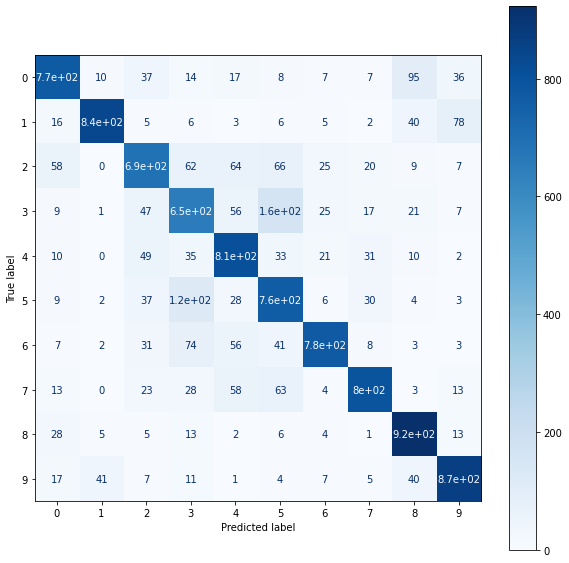


[[769  10  37  14  17   8   7   7  95  36]
 [ 16 839   5   6   3   6   5   2  40  78]
 [ 58   0 689  62  64  66  25  20   9   7]
 [  9   1  47 652  56 165  25  17  21   7]
 [ 10   0  49  35 809  33  21  31  10   2]
 [  9   2  37 120  28 761   6  30   4   3]
 [  7   2  31  74  56  41 775   8   3   3]
 [ 13   0  23  28  58  63   4 795   3  13]
 [ 28   5   5  13   2   6   4   1 923  13]
 [ 17  41   7  11   1   4   7   5  40 867]]

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1000
           1       0.93      0.84      0.88      1000
           2       0.74      0.69      0.71      1000
           3       0.64      0.65      0.65      1000
           4       0.74      0.81      0.77      1000
           5       0.66      0.76      0.71      1000
           6       0.88      0.78      0.82      1000
           7       0.87      0.80      0.83      1000
           8       0.80      0.92      0.86      1000
    

In [66]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

# Final Results

In [67]:
import json
print(json.dumps(all_accuracy, indent=4, sort_keys=True))


{
    "CNN_Inception_V1": {
        "Test": 78.43999862670898,
        "Train": 84.53249931335449
    },
    "CNN_Inception_V3": {
        "Test": 78.78999710083008,
        "Train": 87.51833438873291
    },
    "Functional_API_MLP_With_Dropout": {
        "Test": 59.619998931884766,
        "Train": 96.36666774749756
    },
    "Functional_API_MLP_Without_Dropout": {
        "Test": 57.580000162124634,
        "Train": 100.0
    },
    "Second_MLP_Network": {
        "Test": 57.59999752044678,
        "Train": 82.72583484649658
    },
    "Two_Layer_MLP": {
        "Test": 56.610000133514404,
        "Train": 96.93750143051147
    }
}
